In [0]:
delta_input_path_rr = "/Volumes/workspace/default/retail_delta_2"
retailrocket_df = spark.read.format("delta").load(delta_input_path_rr)

display(retailrocket_df.limit(5))


transactionid,event_indexed_mean,event_index_mean,itemid_index_mean,time_to_purchase_mean,year_mean,month_mean,day_mean,weekday_mean,weekofyear_mean,events_per_session_mean,add_to_cart_ratio_mean
17149,2.0,2.0,0.0,0.0,2015.0,6.0,15.0,2.0,25.0,1.0,0.0
12914,2.0,2.0,0.0,0.0,2015.0,6.0,17.0,4.0,25.0,1.0,0.0
4366,2.0,2.0,0.0,0.0,2015.0,6.0,23.0,3.0,26.0,1.0,0.0
1021,2.0,2.0,0.0,0.0,2015.0,6.0,29.0,2.0,27.0,2.0,0.0
2737,2.0,2.0,0.0,0.0,2015.0,6.0,21.0,1.0,25.0,1.0,0.0


In [0]:

# 2. Кореляційний аналіз та видалення сильно корельованих ознак

import numpy as np
from pyspark.sql.functions import col, when, avg, lit
from pyspark.sql.window import Window

numeric_cols_rr = [
    "event_indexed_mean", "event_index_mean", "itemid_index_mean",
    "time_to_purchase_mean", "year_mean", "month_mean", "day_mean",
    "weekday_mean", "weekofyear_mean", "events_per_session_mean",
    "add_to_cart_ratio_mean"
]

# Кореляційна матриця (Pandas)
df_numeric_rr_pd = retailrocket_df.select(numeric_cols_rr).toPandas()
corr_matrix_rr = df_numeric_rr_pd.corr()
print("Кореляційна матриця числових ознак RetailRocket:")
print(corr_matrix_rr)

# сильно корельовані пари |r| > 0.8
threshold = 0.8
high_corr_rr = np.where(np.abs(corr_matrix_rr) > threshold)
high_corr_pairs_rr = [(numeric_cols_rr[i], numeric_cols_rr[j], corr_matrix_rr.iloc[i,j])
                      for i,j in zip(*high_corr_rr) if i < j]

print("\nСильно корельовані пари (|r| > 0.8):")
for pair in high_corr_pairs_rr:
    print(pair)

# Видаляємо сильно корельовані ознаки
for col1, col2, corr_val in high_corr_pairs_rr:
    print(f"Видаляємо {col2} через сильну кореляцію з {col1} (r={corr_val:.2f})")
    if col2 in retailrocket_df.columns:
        retailrocket_df = retailrocket_df.drop(col2)
        if col2 in numeric_cols_rr:
            numeric_cols_rr.remove(col2)


Кореляційна матриця числових ознак RetailRocket:
                         event_indexed_mean  ...  add_to_cart_ratio_mean
event_indexed_mean                 1.000000  ...               -1.000000
event_index_mean                   1.000000  ...               -1.000000
itemid_index_mean                 -0.000029  ...                0.000029
time_to_purchase_mean              0.999960  ...               -0.999960
year_mean                               NaN  ...                     NaN
month_mean                        -0.000003  ...                0.000003
day_mean                           0.000105  ...               -0.000105
weekday_mean                      -0.000243  ...                0.000243
weekofyear_mean                    0.000072  ...               -0.000072
events_per_session_mean           -1.000000  ...                1.000000
add_to_cart_ratio_mean            -1.000000  ...                1.000000

[11 rows x 11 columns]

Сильно корельовані пари (|r| > 0.8):
('event_index

In [0]:
# 3. Створення нових ознак

w = Window.partitionBy() 

retailrocket_df = retailrocket_df.withColumn(
    "event_indexed_sq", col("event_indexed_mean")**2
).withColumn(
    "event_item_interaction", col("event_indexed_mean") * col("itemid_index_mean")
).withColumn(
    "month_ratio", col("month_mean") / lit(12)
).withColumn(
    "high_event_indexed", when(col("event_indexed_mean") > 1, 1).otherwise(0)
).withColumn(
    "event_indexed_diff_avg", col("event_indexed_mean") - avg("event_indexed_mean").over(w)
)

numeric_cols_rr += [
    "event_indexed_sq", "event_item_interaction",
    "month_ratio", "high_event_indexed", "event_indexed_diff_avg"
]

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
# 4. Масштабування ознак

from pyspark.ml.feature import VectorAssembler, StandardScaler

cols_to_drop = ["numeric_vector_scaled", "numeric_scaled_features"]
for c in cols_to_drop:
    if c in retailrocket_df.columns:
        retailrocket_df = retailrocket_df.drop(c)

assembler = VectorAssembler(inputCols=numeric_cols_rr, outputCol="numeric_vector_scaled")
retailrocket_df = assembler.transform(retailrocket_df)

scaler = StandardScaler(
    inputCol="numeric_vector_scaled",
    outputCol="numeric_scaled_features",
    withMean=True,
    withStd=True
)
scaler_model = scaler.fit(retailrocket_df)
retailrocket_df = scaler_model.transform(retailrocket_df)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:
# 5a. PCA loadings
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="numeric_scaled_features", outputCol="pca_features")
pca_model = pca.fit(retailrocket_df)
retailrocket_df = pca_model.transform(retailrocket_df)

explained_var = pca_model.explainedVariance.toArray().sum()
print(f"Сумарна пояснена дисперсія PCA (5 компонент): {explained_var:.4f}")

pca_loadings = np.array(pca_model.pc.toArray())
feature_importance_pca = np.sum(np.abs(pca_loadings), axis=1)

top_features_pca = sorted(
    zip(numeric_cols_rr, feature_importance_pca),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Топ-10 ознак за важливістю PCA loadings:")
for name, weight in top_features_pca:
    print(f"{name}: {weight:.6f}")

# ---------------------------------------------
# 5b. Variance Threshold
from pyspark.ml.stat import Summarizer

assembler_var = VectorAssembler(inputCols=numeric_cols_rr, outputCol="features_vec_var")
df_vec_var = assembler_var.transform(retailrocket_df)

summarizer = Summarizer.metrics("variance")
variance_df = df_vec_var.select(Summarizer.variance(df_vec_var["features_vec_var"]).alias("variances")).collect()
variances = variance_df[0]["variances"]

variance_threshold = 0.01
selected_features_var = [col_name for col_name, var in zip(numeric_cols_rr, variances) if var > variance_threshold]

print("\nОзнаки, відібрані за порогом дисперсії (>0.01):")
print(selected_features_var)

# Порівняння з PCA
pca_top_names = [name for name, _ in top_features_pca]
print("\nПорівняння ознак: PCA top-10 vs Variance Threshold")
print("PCA:", pca_top_names)
print("Variance Threshold:", selected_features_var)

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Сумарна пояснена дисперсія PCA (5 компонент): 1.0000
Топ-10 ознак за важливістю PCA loadings:
day_mean: 1.282179
month_ratio: 1.117921
month_mean: 1.117921
weekday_mean: 1.035467
event_item_interaction: 0.995544
itemid_index_mean: 0.995219
event_indexed_mean: 0.500403
event_indexed_diff_avg: 0.500403
high_event_indexed: 0.500403
event_indexed_sq: 0.500403

Ознаки, відібрані за порогом дисперсії (>0.01):
['itemid_index_mean', 'month_mean', 'day_mean', 'weekday_mean', 'event_item_interaction', 'month_ratio']

Порівняння ознак: PCA top-10 vs Variance Threshold
PCA: ['day_mean', 'month_ratio', 'month_mean', 'weekday_mean', 'event_item_interaction', 'itemid_index_mean', 'event_indexed_mean', 'event_indexed_diff_avg', 'high_event_indexed', 'event_indexed_sq']
Variance Threshold: ['itemid_index_mean', 'month_mean', 'day_mean', 'weekday_mean', 'event_item_interaction', 'month_ratio']


In [0]:
%pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 MB 168.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
/databricks/python_shell/lib/dbruntime/autoreload/discoverability/autoreload_discoverability_hook.py:72: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  return orig_warn(*args, **kwargs)
/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


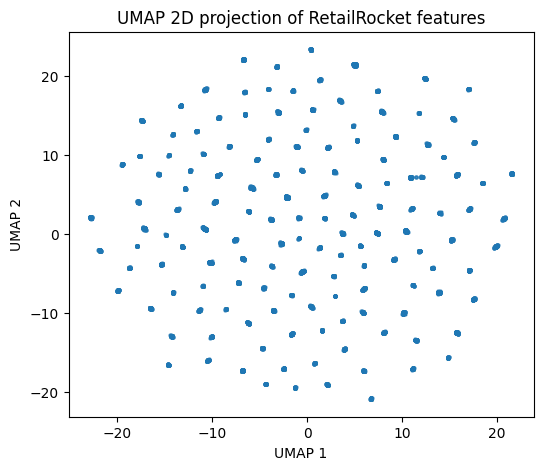

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


In [0]:

import umap
import pandas as pd
from pyspark.sql import functions as F

features_pd = retailrocket_df.select("numeric_scaled_features").toPandas()
features_array = np.vstack(features_pd["numeric_scaled_features"].values)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_model.fit_transform(features_array)

umap_df = pd.DataFrame(umap_features, columns=["umap_1", "umap_2"])

# Конвертуємо у Spark DataFrame
umap_spark_df = spark.createDataFrame(umap_df)
retailrocket_df = retailrocket_df.withColumn("row_idx", F.monotonically_increasing_id())
umap_spark_df = umap_spark_df.withColumn("row_idx", F.monotonically_increasing_id())

retailrocket_df = retailrocket_df.join(umap_spark_df, on="row_idx").drop("row_idx")

# scatter plot
import matplotlib.pyplot as plt

umap_pd = retailrocket_df.select("umap_1", "umap_2").toPandas()
plt.figure(figsize=(6,5))
plt.scatter(umap_pd["umap_1"], umap_pd["umap_2"], s=5, alpha=0.6)
plt.title("UMAP 2D projection of RetailRocket features")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [0]:

output_path_rr_final = "/Volumes/workspace/default/retail_delta_3"
retailrocket_df.write.format("delta").mode("overwrite").save(output_path_rr_final)

print("Фінальний набір ознак RetailRocket успішно збережено в Delta Lake!")

/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/expressions.py:1134: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


Фінальний набір ознак RetailRocket успішно збережено в Delta Lake!
